In [13]:
pip install torch
pip install torchvision
pip install matplotlib
pip install tqdm

DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/tk-0.1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 2.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
# Cellule 1
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
# Cellule 2
device = "cuda" if torch.cuda.is_available() else "cpu"
device

Matplotlib is building the font cache; this may take a moment.


'cpu'

In [31]:
tf = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
train_loader = torch.utils.data.DataLoader(datasets.MNIST("../data/raw", download=True, train=True, transform=tf),
batch_size=64, shuffle=True)
test_load = torch.utils.data.DataLoader(datasets.MNIST("../data/raw", download=True, train=False, transform=tf),
batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../data/raw/MNIST/raw/train-images-idx3-ubyte.gz to ../data/raw/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../data/raw/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/raw/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../data/raw/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/raw/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting ../data/raw/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/raw/MNIST/raw



In [11]:

batch = next(iter(train_loader))
x = batch[0][:10]
y = batch[1][:10]

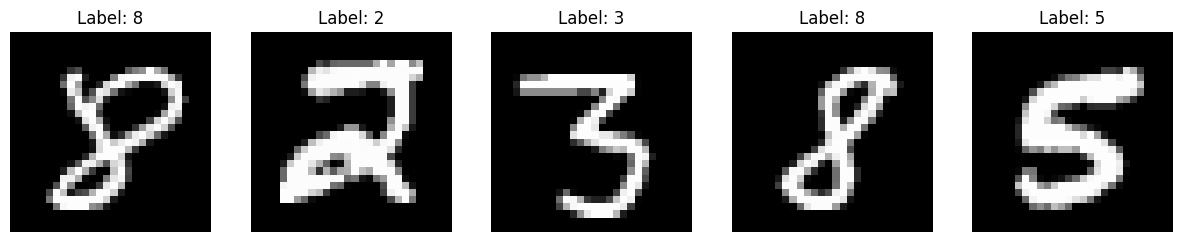

In [12]:
# Afficher les 5 premières images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax = axes[i]
    image = x[i].numpy().squeeze()
    label = y[i].item()
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.show()

In [41]:

class ConvNet(nn.Module):
    def __init__(self, input_size, n_kernels, output_size):
        super(ConvNet, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n_kernels, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=n_kernels, out_channels=n_kernels, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(in_features=n_kernels*4*4, out_features=50),
            nn.Linear(in_features=50, out_features=output_size)
        )
    
    def forward(self, x):
        return self.net(x)

In [42]:

from torch.optim import AdamW
from tqdm import tqdm

def train(model, train_loader, device, perm=torch.arange(0, 784).long(), n_epoch=1):
    model.train()
    optimizer = AdamW(model.parameters())
    
    for epoch in range(n_epoch):
        print(f"Epoch {epoch+1}/{n_epoch}")
        for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 28*28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)
            optimizer.zero_grad()
            logits = model(data)
            loss = F.cross_entropy(logits, target)
            
            # Rétropropagation
            loss.backward()
            
            # Mise à jour des poids
            optimizer.step()
            
            # Affichage tous les 100 itérations
            if batch_idx % 100 == 0:
                print(f'Iter: {batch_idx}, Loss: {loss.item()}')


In [43]:

def test(model, test_loader, device, perm=torch.arange(0, 784).long()):
    # Initialisation des variables
    test_loss = 0
    correct = 0

    # Mode évaluation
    model.eval()

    with torch.no_grad():
        for data, target in test_loader:
            # Envoyer les données vers la carte graphique
            data, target = data.to(device), target.to(device)

            # Appliquer les permutations de pixels
            data = data.view(-1, 28*28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)

            # Prédiction
            logits = model(data)

            # Calculer le loss
            test_loss += F.cross_entropy(logits, target, reduction='sum').item()

            # Prédiction finale
            pred = torch.argmax(logits, dim=1)

            # Compter les prédictions correctes
            correct += pred.eq(target).sum().item()

    # Calculer le loss moyen
    test_loss /= len(test_loader.dataset)

    # Calculer l'accuracy
    accuracy = correct / len(test_loader.dataset)

    # Afficher les résultats
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy * 100:.2f}%)')


In [44]:
n_kernels = 6
input_size = 28*28
output_size = 10
convnet = ConvNet(input_size, n_kernels, output_size)
convnet.to(device)
print(f"Parameters={sum(p.numel() for p in convnet.parameters())/1e3}K")
train(convnet, train_loader, device, n_epoch=1)
test(convnet, test_load, device)

Parameters=6.422K
Epoch 1/1


  0%|          | 1/938 [00:00<02:04,  7.50it/s]

Iter: 0, Loss: 2.2678887844085693


 12%|█▏        | 111/938 [00:01<00:11, 72.33it/s]

Iter: 100, Loss: 0.3149380087852478


 23%|██▎       | 212/938 [00:03<00:08, 82.97it/s]

Iter: 200, Loss: 0.5071640014648438


 33%|███▎      | 311/938 [00:04<00:07, 81.75it/s]

Iter: 300, Loss: 0.20256835222244263


 44%|████▎     | 409/938 [00:05<00:07, 73.20it/s]

Iter: 400, Loss: 0.15307876467704773


 55%|█████▌    | 516/938 [00:07<00:05, 78.64it/s]

Iter: 500, Loss: 0.23416903614997864


 66%|██████▌   | 617/938 [00:08<00:03, 86.82it/s]

Iter: 600, Loss: 0.1532072275876999


 76%|███████▋  | 717/938 [00:09<00:02, 79.80it/s]

Iter: 700, Loss: 0.11098623275756836


 87%|████████▋ | 816/938 [00:10<00:01, 86.02it/s]

Iter: 800, Loss: 0.20151257514953613


 97%|█████████▋| 914/938 [00:12<00:00, 69.88it/s]

Iter: 900, Loss: 0.13099420070648193


100%|██████████| 938/938 [00:12<00:00, 75.07it/s]


Test set: Average loss: 0.1028, Accuracy: 9687/10000 (96.87%)


In [25]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.net(x)

In [46]:
# Exemple d'utilisation
input_size = 28*28  # Taille des images MNIST aplaties
output_size = 10    # Nombre de classes pour MNIST
n_hidden = 8        # Taille des couches cachées

mlp = MLP(input_size, n_hidden, output_size)
mlp.to(device)
print(f"Parameters={sum(p.numel() for p in mlp.parameters())/1e3}K")

# Entraîner le modèle
train(mlp, train_loader, device)

# Tester le modèle
test(mlp, test_load, device)

Parameters=6.442K
Epoch 1/1


  0%|          | 1/938 [00:00<01:58,  7.94it/s]

Iter: 0, Loss: 2.2996392250061035


 14%|█▍        | 133/938 [00:00<00:04, 178.42it/s]

Iter: 100, Loss: 1.250817060470581


 24%|██▍       | 226/938 [00:01<00:03, 220.76it/s]

Iter: 200, Loss: 1.0092811584472656


 37%|███▋      | 350/938 [00:01<00:02, 241.52it/s]

Iter: 300, Loss: 0.6830857396125793


 48%|████▊     | 449/938 [00:02<00:02, 210.83it/s]

Iter: 400, Loss: 0.6433494091033936


 59%|█████▊    | 551/938 [00:02<00:01, 240.87it/s]

Iter: 500, Loss: 0.39947935938835144


 67%|██████▋   | 627/938 [00:03<00:01, 240.79it/s]

Iter: 600, Loss: 0.5656925439834595


 78%|███████▊  | 729/938 [00:03<00:00, 246.46it/s]

Iter: 700, Loss: 0.53216153383255


 88%|████████▊ | 829/938 [00:03<00:00, 243.89it/s]

Iter: 800, Loss: 0.4207504987716675


100%|██████████| 938/938 [00:04<00:00, 206.37it/s]


Iter: 900, Loss: 0.5299522280693054
Test set: Average loss: 0.3772, Accuracy: 8914/10000 (89.14%)


In [47]:
# convnet est plus perfomrant que mlp convnet utlise les connaissance du passé alors le mlp réappend à chaque fois
perm = torch.randperm(784)

# Entraîner le modèle
train(mlp, train_loader, device, perm)
test(mlp, test_load, device, perm)

# Entraîner le modèle

train(convnet, train_loader, device, perm)
test(convnet, test_load, device, perm)




Epoch 1/1


  0%|          | 2/938 [00:00<00:57, 16.39it/s]

Iter: 0, Loss: 2.4015281200408936


 14%|█▎        | 128/938 [00:00<00:03, 213.55it/s]

Iter: 100, Loss: 0.8647591471672058


 24%|██▎       | 221/938 [00:01<00:03, 224.51it/s]

Iter: 200, Loss: 0.6106679439544678


 37%|███▋      | 345/938 [00:01<00:02, 237.49it/s]

Iter: 300, Loss: 0.3525248169898987


 47%|████▋     | 444/938 [00:02<00:02, 243.37it/s]

Iter: 400, Loss: 0.3290386199951172


 58%|█████▊    | 548/938 [00:02<00:01, 251.50it/s]

Iter: 500, Loss: 0.6904231309890747


 70%|██████▉   | 653/938 [00:02<00:01, 255.02it/s]

Iter: 600, Loss: 0.49210670590400696


 78%|███████▊  | 729/938 [00:03<00:00, 234.24it/s]

Iter: 700, Loss: 0.42001664638519287


 88%|████████▊ | 828/938 [00:03<00:00, 233.56it/s]

Iter: 800, Loss: 0.3148084282875061


100%|██████████| 938/938 [00:04<00:00, 225.04it/s]


Iter: 900, Loss: 0.5138866305351257
Test set: Average loss: 0.3383, Accuracy: 9003/10000 (90.03%)
Epoch 1/1


  1%|          | 6/938 [00:00<00:16, 56.48it/s]

Iter: 0, Loss: 3.4355835914611816


 12%|█▏        | 110/938 [00:01<00:10, 76.07it/s]

Iter: 100, Loss: 1.1559044122695923


 23%|██▎       | 216/938 [00:02<00:08, 84.11it/s]

Iter: 200, Loss: 0.7341693639755249


 34%|███▎      | 315/938 [00:04<00:07, 82.13it/s]

Iter: 300, Loss: 0.6030786633491516


 45%|████▍     | 418/938 [00:05<00:05, 88.26it/s]

Iter: 400, Loss: 0.5831266641616821


 54%|█████▍    | 511/938 [00:06<00:04, 85.52it/s]

Iter: 500, Loss: 0.6368881464004517


 65%|██████▌   | 611/938 [00:07<00:03, 84.26it/s]

Iter: 600, Loss: 0.43598443269729614


 76%|███████▌  | 710/938 [00:08<00:02, 84.43it/s]

Iter: 700, Loss: 0.3822178840637207


 86%|████████▋ | 810/938 [00:09<00:01, 87.03it/s]

Iter: 800, Loss: 0.46010100841522217


 98%|█████████▊| 918/938 [00:11<00:00, 84.40it/s]

Iter: 900, Loss: 0.6395220160484314


100%|██████████| 938/938 [00:11<00:00, 81.30it/s]


Test set: Average loss: 0.4453, Accuracy: 8630/10000 (86.30%)


In [45]:

torch.save(convnet.state_dict(), "../model/mnist-0.0.1.pt.pt")
